In [1]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx

plt.rcParams["text.usetex"] = True

In [2]:
def generate_BA(N,m):
    G = nx.barabasi_albert_graph(N, m, seed=None, initial_graph=None)
    sc = {"nodes": np.reshape(np.array(G.nodes),(-1,1)), "n0":N, "edges":np.array(G.edges)}
    sc["n1"] = len(sc["edges"])
    sc["faces"] = np.zeros((0,3))
    sc["tetrahedra"] = np.zeros((0,4))
    sc["4-simplices"] = np.zeros((0,5))
    sc["n2"] = 0
    sc["n3"] = 0
    sc["n4"] = 0
    return sc


def generate_tlattice(n,m,p):
    G = nx.triangular_lattice_graph(n,m)
    G = nx.convert_node_labels_to_integers(G)
    N = len(G.nodes)
    all_cliques= nx.enumerate_all_cliques(G)
    sc = {"nodes": np.reshape(np.array(G.nodes),(-1,1)), "n0":N, "edges":np.array(G.edges)}
    sc["n1"] = len(sc["edges"])
    sc["faces"] = np.array([x for x in all_cliques if len(x)==3])
    il = []
    for i in range(sc["faces"].shape[0]):
        if np.random.rand() < p:
            il.append(i)
    sc["faces"] = sc["faces"][il,:]
    sc["tetrahedra"] = np.zeros((0,4))
    sc["4-simplices"] = np.zeros((0,5))
    sc["n2"] = sc["faces"].shape[0]
    sc["n3"] = 0
    sc["n4"] = 0
    return sc

def generate_hlattice(n,m):
    G = nx.hexagonal_lattice_graph(n,m)
    G = nx.convert_node_labels_to_integers(G)
    N = len(G.nodes)
    sc = {"nodes": np.reshape(np.array(G.nodes),(-1,1)), "n0":N, "edges":np.array(G.edges)}
    sc["n1"] = len(sc["edges"])
    sc["faces"] = np.zeros((0,3))
    sc["tetrahedra"] = np.zeros((0,4))
    sc["4-simplices"] = np.zeros((0,5))
    sc["n2"] = 0
    sc["n3"] = 0
    sc["n4"] = 0
    return sc

def generate_fractal_cycle(slist):
    s = len(slist)
    edges  = []
    n = 0
    for i in range(s):
        for j in range(slist[i]):
            edges.append([n,n+1])
            n += 1
        edges.append([n,n-slist[i]])
    edges.append([n,0])
    G = nx.from_edgelist(edges)
    N = len(G.nodes)
    sc = {"nodes": np.reshape(np.array(G.nodes),(-1,1)), "n0":N, "edges":np.array(G.edges)}
    sc["n1"] = len(sc["edges"])
    sc["faces"] = np.zeros((0,3))
    sc["tetrahedra"] = np.zeros((0,4))
    sc["4-simplices"] = np.zeros((0,5))
    sc["n2"] = 0
    sc["n3"] = 0
    sc["n4"] = 0
    return sc

def generate_ER(N):
    G = nx.erdos_renyi_graph(N, 1.1*np.log(N)/N, seed=None, directed=False)
    sc = {"nodes": np.reshape(np.array(G.nodes),(-1,1)), "n0":N, "edges":np.array(G.edges)}
    all_cliques= nx.enumerate_all_cliques(G)
    sc["faces"]= np.array([x for x in all_cliques if len(x)==3])
    sc["n1"] = len(sc["edges"])
    sc["tetrahedra"] = np.zeros((0,4))
    sc["4-simplices"] = np.zeros((0,5))
    sc["n2"] = sc["faces"].shape[0]
    sc["n3"] = 0
    sc["n4"] = 0
    return sc

def KS(deg1,deg2):
    test = scipy.stats.kstest(deg1, deg2)
    return test.statistic 


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


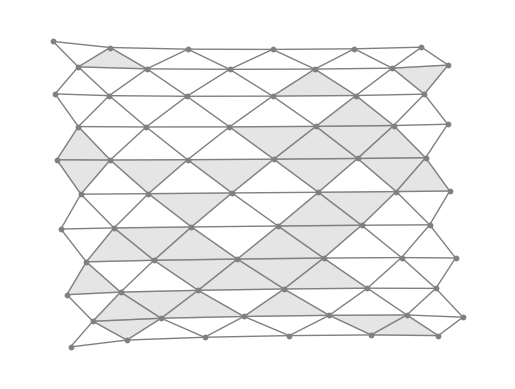

In [3]:
f,ax = plt.subplots(1,1)
sc  = generate_tlattice(10,10,0.3)
plotting.plot_complex(sc,ax = ax,color=[0.5,0.5,0.5])

In [30]:
d = 3
nrep =20
N = 300
specific_heat0 = np.zeros(199)
specific_heat1 = np.zeros(199)
specific_heat2 = np.zeros(199)
for i in range(nrep):
    print(i)
    sc = scomplex.NGF(d,300,1,1)
    #sc =generate_BA(N,1)
    #sc = generate_tlattice(20,20,0.2)
    #sc  = generate_fractal_cycle([10,10,10,10,10])

    B1, B2, __, __, edge_dict, face_dict, tet_dict = scomplex.boundary_matrices_3(sc)
    deg = scomplex.generalized_degree(sc, edge_dict, face_dict, tet_dict, d)

    L0 = (B1@B1.T).todense()
    L1 = (B1.T@B1 + B2@B2.T).todense()
    L2 = (B2.T@B2).todense()
    D0,U0 = scipy.linalg.eigh(L0)
    D1,U1 = scipy.linalg.eigh(L1)
    if sc["n2"] > 0:
        D2,U2 = scipy.linalg.eigh(L2)
    else:
        D2 = [0]

    sp0,tau_space = renormalize.compute_heat(D0,-1,3,200)
    sp1,__ = renormalize.compute_heat(D1,-1,3,200)
    sp2,__ = renormalize.compute_heat(D2,-1,3,200)

    specific_heat0 += sp0/nrep
    specific_heat1 += sp1/nrep
    if sc["n2"]>0:
        specific_heat2 += sp2/nrep


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


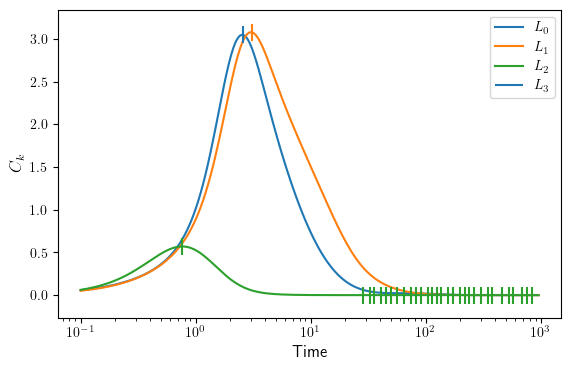

In [33]:
d = 3
f,ax = plt.subplots(1,1,figsize = (6.5,4))
ax.semilogx(tau_space,specific_heat0)
fpeaks = scipy.signal.find_peaks(specific_heat0)[0]

ax.semilogx(tau_space,specific_heat1)
fpeaks1 = scipy.signal.find_peaks(specific_heat1)[0]

if d >= 2:
    ax.semilogx(tau_space,specific_heat2)
    fpeaks2 = scipy.signal.find_peaks(specific_heat2)[0]

for p in fpeaks:    
    ax.vlines(x = tau_space[p], ymin = specific_heat0[p]-0.1, ymax = specific_heat0[p]+0.1, color = "tab:blue")
for p in fpeaks1 :    
    ax.vlines(x = tau_space[p], ymin = specific_heat1[p]-0.1, ymax = specific_heat1[p]+0.1, color = 'tab:orange')

if d >= 2:
    for p in fpeaks2 :    
        ax.vlines(x = tau_space[p], ymin = specific_heat2[p]-0.1, ymax = specific_heat2[p]+0.1, color = 'tab:green')

ax.set_xlabel("Time")
ax.set_ylabel("$C_k$")
plt.legend([f"$L_{i}$" for i in range(d+1)])

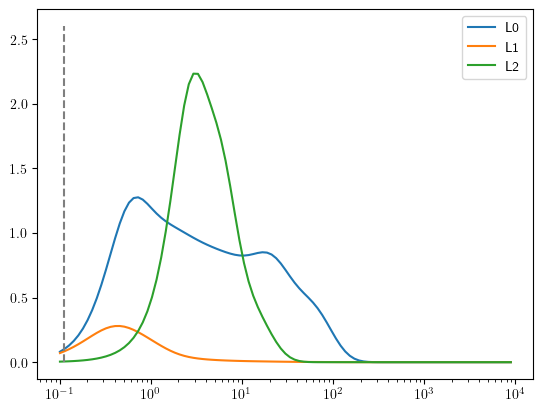

In [163]:
tau_space = np.logspace(-1,4,100)
tau_space = tau_space[0:99]
plt.semilogx(tau_space,specific_heat0)
plt.semilogx(tau_space,specific_heat1)
plt.semilogx(tau_space,specific_heat2)
plt.vlines(x = 1/np.max(D0[D0>10**-6]), ymin = 0, ymax = 2.6, linestyles='dashed', color = "tab:gray")
plt.legend(["L0","L1","L2"])


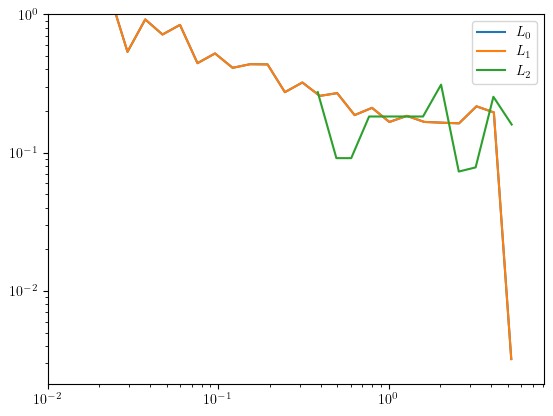

In [108]:
import powerlaw as pwl
pwl.plot_pdf(eig0[eig0 >0])

pwl.plot_pdf(eig1[eig1 >0])
pwl.plot_pdf(eig2[eig2 >0])

plt.xlim(xmin = 0.01)
plt.ylim(ymax = 1)
plt.legend(["$L_0$","$L_1$","$L_2$"])


In [171]:
degg = 0
n_tau = 8
taumax = 0.3
taumin = 0
tau0 = np.linspace(taumin,taumax,n_tau)

lmax = 5
mdeg = np.zeros((n_tau,lmax)) 
measuredeg = np.zeros((n_tau,lmax)) 
measurespectr = np.zeros((n_tau,lmax,d+1))
Ns = np.zeros((n_tau,lmax))

for t in range(n_tau):
    new_sc = sc
    for i in range(lmax):
        B1, B2, __, __, new_edge_dict, new_face_dict, new_tet_dict = scomplex.boundary_matrices_3(new_sc)

        L0 = (B1@B1.T).todense()
        L1 = (B1.T@B1 + B2@B2.T).todense()
        L2 = (B2.T@B2).todense()
        D0,U0 = scipy.linalg.eigh(L0)
        if new_sc["n1"] > 0:
            D1,U1 = scipy.linalg.eigh(L1)
        if new_sc["n2"] > 0:
            D2,U2 = scipy.linalg.eigh(L2)
        measurespectr[t,i,0] = KS(D0i,D0)
        measurespectr[t,i,1] = KS(D1i,D1)
        if L2.shape[0] > 0 :
            measurespectr[t,i,2] = KS(D2i,D2)
        
        L0 = (B1@B1.T).todense()
        D0,U0 = scipy.linalg.eigh(L0)
        new_deg = scomplex.generalized_degree(new_sc, new_edge_dict, new_face_dict, new_tet_dict, 2)
        Ns[t,i] = new_sc["n0"]
        mdeg[t,i] = np.mean(new_deg[degg]) 
        if len(new_deg[degg]) == 0:
            new_deg[degg] = [0]
        measuredeg[t,i] = KS(deg[degg],new_deg[degg])
        new_sc, __, __, __= renormalize.renormalize_simplicial_VARIANTS(new_sc,0,L0,U0,D0,tau0[t],simple = False)               


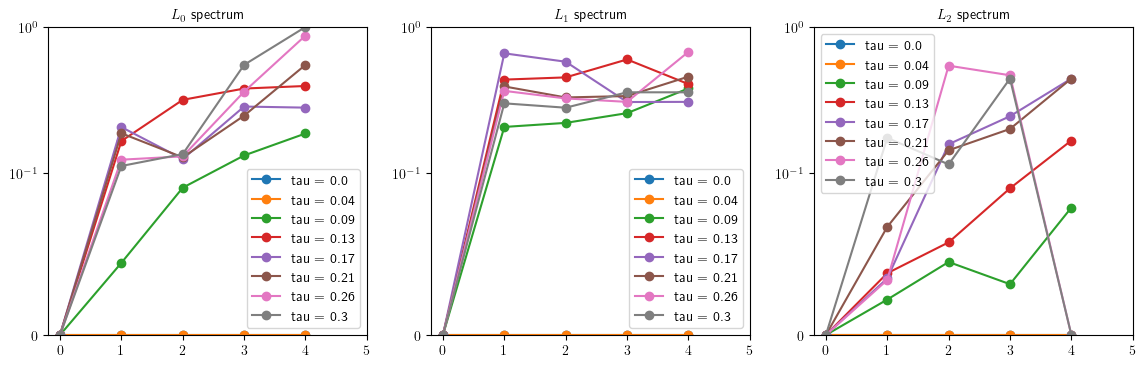

In [136]:
fig,axs = plt.subplots(1,d+1,figsize = (14,4) )
for i in range(d+1):
    axs[i].plot(measurespectr[:,:,i].T,'-o')
    axs[i].set_ylim(ymin=0,ymax = 1)
    axs[i].set_yscale("symlog",linthresh=0.1)
    axs[i].legend([f"tau = {np.round(tau0[t],2)}" for t in range(n_tau)])
    axs[i].set_title(f"$L_{i}$ spectrum")
    axs[i].set_xticks([j for j in range(lmax +1)])
# for i in range(d+1):
#     axs[i].plot(measurespectr1[:,:,i].T, color = "tab:blue")
#     axs[i].set_ylim(ymin=0,ymax = 1)
#     axs[i].set_yscale("symlog",linthresh=0.1)

plt.savefig("../Tests/Paperlike/" + suff + "/stats_L0_spectrum.pdf", format="pdf")  # , bbox_inches="tight")

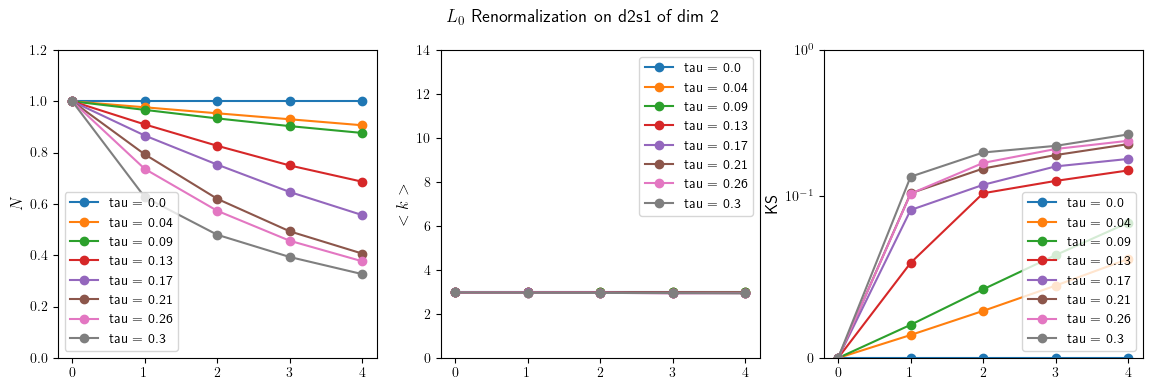

In [172]:
fig,axs = plt.subplots(1,3,figsize = (14,4))

axs[0].plot(np.linspace(0,lmax-1,lmax),Ns.T/300,'-o')
axs[0].legend([f"tau = {np.round(tau,2)}" for tau in tau0])
axs[0].set_ylim(ymin = 0, ymax = 1.2)
axs[0].set_ylabel("$N$")


axs[1].plot(np.linspace(0,lmax-1,lmax),mdeg.T,'-o')
axs[1].legend([f"tau = {np.round(tau,2)}" for tau in tau0])
axs[1].set_ylim(ymin = 0, ymax = 14)
axs[1].set_ylabel("$<k>$")

axs[2].plot(np.linspace(0,lmax-1,lmax),measuredeg.T,'-o')
axs[2].legend([f"tau = {np.round(tau,2)}" for tau in tau0])
axs[2].set_ylim(ymin = 0, ymax = 1)
axs[2].set_yscale("symlog", linthresh=0.1)
axs[2].set_ylabel("KS")

fig.suptitle(f"$L_0$ Renormalization on {suff} of dim {d}")
plt.savefig( f"../Tests/Paperlike/" + suff + f"/stats_L0_node_face.pdf", format="pdf")  # , bbox_inches="tight")

In [184]:
degg = 1
n_tau = 8
taumax = 0.5#0.39
taumin = 0
tau1 = np.linspace(taumin,taumax,n_tau)

lmax = 5
mdeg1 = np.zeros((n_tau,lmax)) 
measuredeg1 = np.zeros((n_tau,lmax)) 
Ns1 = np.zeros((n_tau,lmax))

measurespectr1 = np.zeros((n_tau,lmax,d+1))

for t in range(n_tau):
    new_sc1 = sc
    for i in range(lmax):
        B1, B2, __, __, new_edge_dict, new_face_dict, new_tet_dict = scomplex.boundary_matrices_3(new_sc1)

        L0 = (B1@B1.T).todense()
        L1 = (B1.T@B1 + B2@B2.T).todense()
        L2 = (B2.T@B2).todense()
        D0,U0 = scipy.linalg.eigh(L0)
        D1,U1 = scipy.linalg.eigh(L1)
        if new_sc["n2"] > 0:
            D2,U2 = scipy.linalg.eigh(L2)
        measurespectr1[t,i,0] = KS(D0i,D0)
        measurespectr1[t,i,1] = KS(D1i,D2)
        if new_sc["n2"] > 0:
            measurespectr1[t,i,2] = KS(D2i,D2)

        L1 = (B1.T@B1 + B2@B2.T).todense()
        new_deg = scomplex.generalized_degree(new_sc1, new_edge_dict, new_face_dict, new_tet_dict,d)
        Ns1[t,i] = new_sc1["n0"]
        mdeg1[t,i] = np.mean(new_deg[degg])  
        if len(new_deg[degg]) == 0:
            new_deg[degg] = [0]
        measuredeg1[t,i] = KS(deg[degg],new_deg[degg])
        if new_sc1["n1"] > 0:
            D1,U1 = scipy.linalg.eigh(L1)
            new_sc1, __, __, __= renormalize.renormalize_simplicial_VARIANTS(new_sc1,order = 1,U = U1,D = D1,tau = tau1[t],simple = False, METHOD = "representative") 
       
               


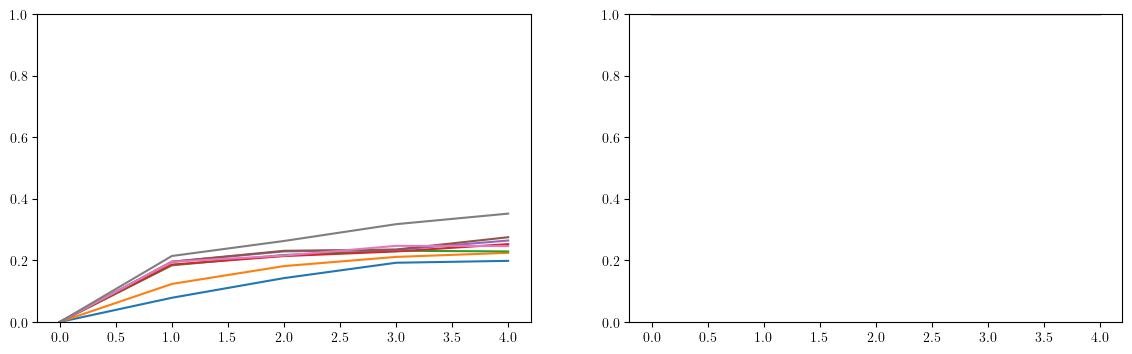

In [62]:
fig,axs = plt.subplots(1,d+1,figsize = (14,4) )
for i in range(d+1):
    axs[i].plot(measurespectr1[:,:,i].T)
    axs[i].set_ylim(ymin=0,ymax = 1)

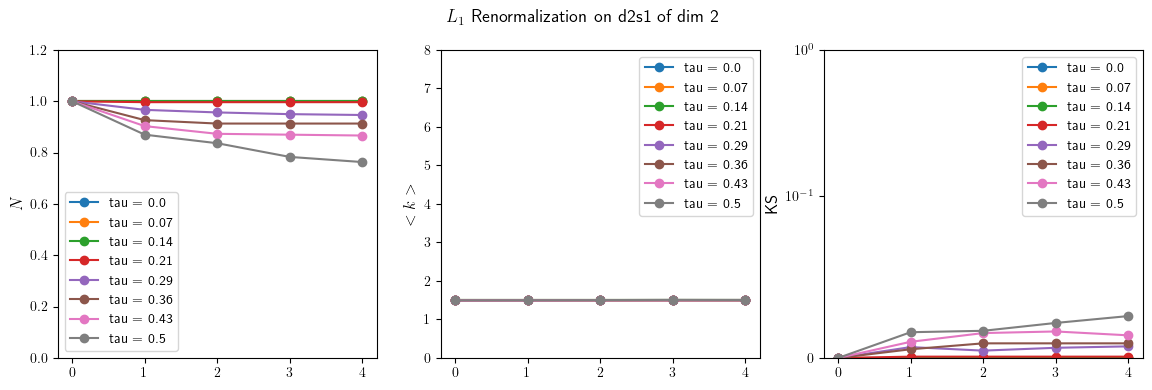

In [185]:
fig,axs = plt.subplots(1,3,figsize = (14,4))
axs[0].plot(np.linspace(0,lmax-1,lmax),Ns1.T/300,'-o')
axs[0].legend([f"tau = {np.round(tau,2)}" for tau in tau1])
axs[0].set_ylim(ymin = 0, ymax = 1.2)
axs[0].set_ylabel("$N$")

axs[1].plot(np.linspace(0,lmax-1,lmax),mdeg1.T,'-o')
axs[1].legend([f"tau = {np.round(tau,2)}" for tau in tau1])
axs[1].set_ylim(ymin = 0, ymax = 8)
axs[1].set_ylabel("$<k>$")

axs[2].plot(np.linspace(0,lmax-1,lmax),measuredeg1.T,'-o')
axs[2].legend([f"tau = {np.round(tau,2)}" for tau in tau1])
axs[2].set_ylim(ymin = 0, ymax = 1)
axs[2].set_yscale("symlog", linthresh=0.1)
axs[2].set_ylabel("KS")

fig.suptitle(f"$L_1$ Renormalization on {suff} of dim {d}")
plt.savefig( f"../Tests/Paperlike/" + suff + f"/stats_L1_deg_link_face.pdf", format="pdf")  # , bbox_inches="tight")

In [186]:
degg = 0
n_tau = 8
taumax = 0.4
taumin = 0
tau2 = np.linspace(taumin,taumax,n_tau)

lmax = 5
mdeg2 = np.zeros((n_tau,lmax)) 
measuredeg2 = np.zeros((n_tau,lmax)) 
Ns2 = np.zeros((n_tau,lmax))

for t in range(n_tau):
    new_sc2 = sc
    for i in range(lmax):
        B1, B2, B3, __, new_edge_dict, new_face_dict, new_tet_dict = scomplex.boundary_matrices_3(new_sc2)
        L2 = (B2.T@B2 + B3@B3.T).todense()
        new_deg = scomplex.generalized_degree(new_sc2, new_edge_dict, new_face_dict, new_tet_dict, d)
        Ns2[t,i] = new_sc2["n0"]
        mdeg2[t,i] = np.mean(new_deg[degg])  
        if len(new_deg[degg]) == 0:
            new_deg[degg] = [0]
        measuredeg2[t,i] = KS(deg[degg],new_deg[degg])
        if new_sc2["n2"] > 0:
            D2,U2 = scipy.linalg.eigh(L2)
            new_sc2, __, __, __= renormalize.renormalize_simplicial_VARIANTS(new_sc2,order = 2,U = U2,D = D2,tau = tau2[t],simple = False)                


/Users/marconurisso/Desktop/Work/Simplicial_Renormalization/HodgeLaplacianRenorm/hodge_renormalization/Hodge_renorm/Experiments_setups/../Functions/renormalize.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  ncut = np.sum(D > 1 / np.abs(tau))  # Number of simplices to remove


FileNotFoundError: [Errno 2] No such file or directory: '../Tests/Paperlike/d2/stats_L2.pdf'

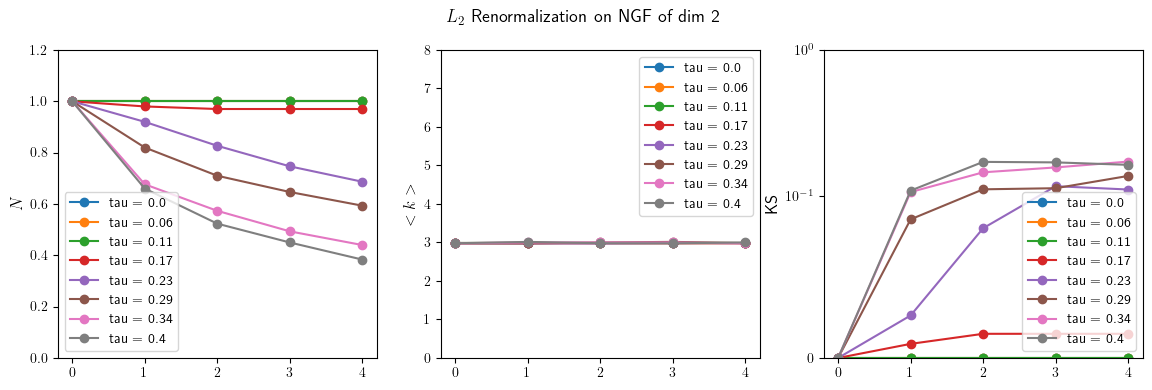

In [187]:
fig,axs = plt.subplots(1,3,figsize = (14,4))
axs[0].plot(np.linspace(0,lmax-1,lmax),Ns2.T/300,'-o')
axs[0].legend([f"tau = {np.round(tau,2)}" for tau in tau2])
axs[0].set_ylim(ymin = 0, ymax = 1.2)
axs[0].set_ylabel("$N$")

axs[1].plot(np.linspace(0,lmax-1,lmax),mdeg2.T,'-o')
axs[1].legend([f"tau = {np.round(tau,2)}" for tau in tau2])
axs[1].set_ylim(ymin = 0, ymax = 8)
axs[1].set_ylabel("$<k>$")

axs[2].plot(np.linspace(0,lmax-1,lmax),measuredeg2.T,'-o')
axs[2].legend([f"tau = {np.round(tau,2)}" for tau in tau2])
axs[2].set_ylim(ymin = 0, ymax = 1)
axs[2].set_yscale("symlog", linthresh=0.1)
axs[2].set_ylabel("KS")

fig.suptitle(f"$L_2$ Renormalization on NGF of dim {d}")
plt.savefig( f"../Tests/Paperlike/d{d}/stats_L2.pdf", format="pdf")  # , bbox_inches="tight")

In [412]:
degg = 1
n_tau = 8
taumax = 2
taumin = 0.3
tau3 = np.linspace(taumin,taumax,n_tau)

lmax = 5
mdeg3 = np.zeros((n_tau,lmax)) 
measuredeg3 = np.zeros((n_tau,lmax)) 
Ns3 = np.zeros((n_tau,lmax))

for t in range(n_tau):
    new_sc3 = sc
    for i in range(lmax):
        B1, B2, B3, __, new_edge_dict, new_face_dict, new_tet_dict = scomplex.boundary_matrices_3(new_sc3)
        L3 = (B3.T@B3).todense()
        new_deg = scomplex.generalized_degree(new_sc3, new_edge_dict, new_face_dict, new_tet_dict, d)
        Ns3[t,i] = new_sc3["n0"]
        mdeg3[t,i] = np.mean(new_deg[degg])  
        if len(new_deg[degg]) == 0:
            new_deg[degg] = [0]
        measuredeg3[t,i] = KS(deg[degg],new_deg[degg])
        if new_sc3["n3"] > 0:
            D3,U3 = scipy.linalg.eigh(L3)
            new_sc3, __, __, __= renormalize.renormalize_simplicial_VARIANTS(new_sc3,order = 3,U = U3,D = D3,tau = tau3[t],simple = True)                


Text(0.5, 0.98, '$L_3$ Renormalization on NGF of dim 3')

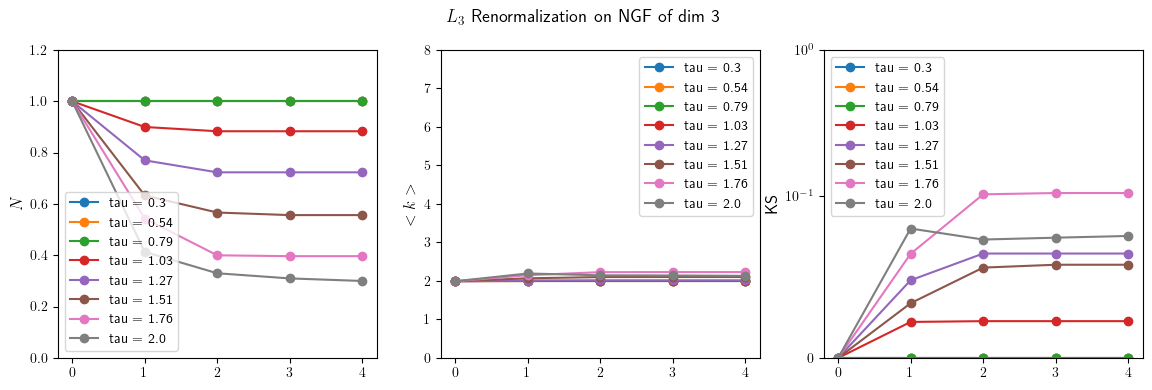

In [413]:
fig,axs = plt.subplots(1,3,figsize = (14,4))
axs[0].plot(np.linspace(0,lmax-1,lmax),Ns3.T/300,'-o')
axs[0].legend([f"tau = {np.round(tau,2)}" for tau in tau3])
axs[0].set_ylim(ymin = 0, ymax = 1.2)
axs[0].set_ylabel("$N$")

axs[1].plot(np.linspace(0,lmax-1,lmax),mdeg3.T,'-o')
axs[1].legend([f"tau = {np.round(tau,2)}" for tau in tau3])
axs[1].set_ylim(ymin = 0, ymax = 8)
axs[1].set_ylabel("$<k>$")

axs[2].plot(np.linspace(0,lmax-1,lmax),measuredeg3.T,'-o')
axs[2].legend([f"tau = {np.round(tau,2)}" for tau in tau3])
axs[2].set_ylim(ymin = 0, ymax = 1)
axs[2].set_yscale("symlog", linthresh=0.1)
axs[2].set_ylabel("KS")

fig.suptitle(f"$L_3$ Renormalization on NGF of dim {d}")
#plt.savefig( f"../Tests/Paperlike/d{d}/stats_L3.pdf", format="pdf")  # , bbox_inches="tight")

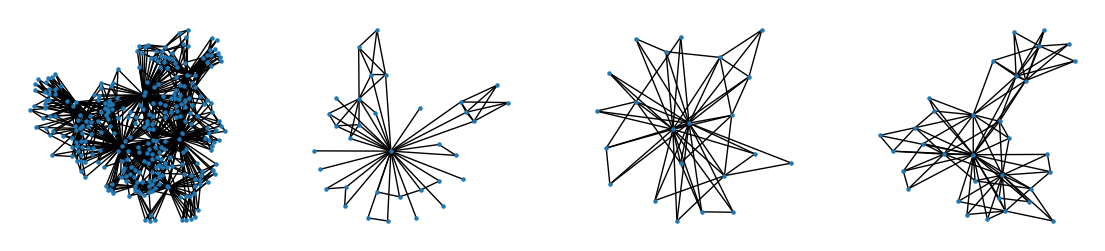

In [342]:
fig,axs = plt.subplots(1,4,figsize = (14,3))
G = nx.from_edgelist(sc["edges"])
pos = nx.spring_layout(G)
nx.draw(G,pos = pos, node_size = 5, ax = axs[0])
nx.draw_spring(nx.from_edgelist(new_sc["edges"]),node_size = 5, ax = axs[1])
nx.draw_spring(nx.from_edgelist(new_sc1["edges"]),node_size = 5, ax = axs[2])
nx.draw_spring(nx.from_edgelist(new_sc2["edges"]),node_size = 5, ax = axs[3])